# AA1 Machine learning competition

We'll first install all the necessary libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from pandas import read_csv

In [7]:
Liver_data = read_csv("liver-patient-classification/test_data_ILDS.csv", delimiter = ',')
Liver_data.columns = ["Age", "Female", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]

In [10]:
Liver_data.head()

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R
0,62,0,1.8,0.9,224,69,155,8.6,4.0,0.80
1,60,0,0.7,0.2,174,32,14,7.8,4.2,1.10
2,60,0,5.7,2.8,214,412,850,7.3,3.2,0.78
3,48,1,0.9,0.2,175,24,54,5.5,2.7,0.90
4,42,1,0.9,0.2,165,26,29,8.5,4.4,1.00


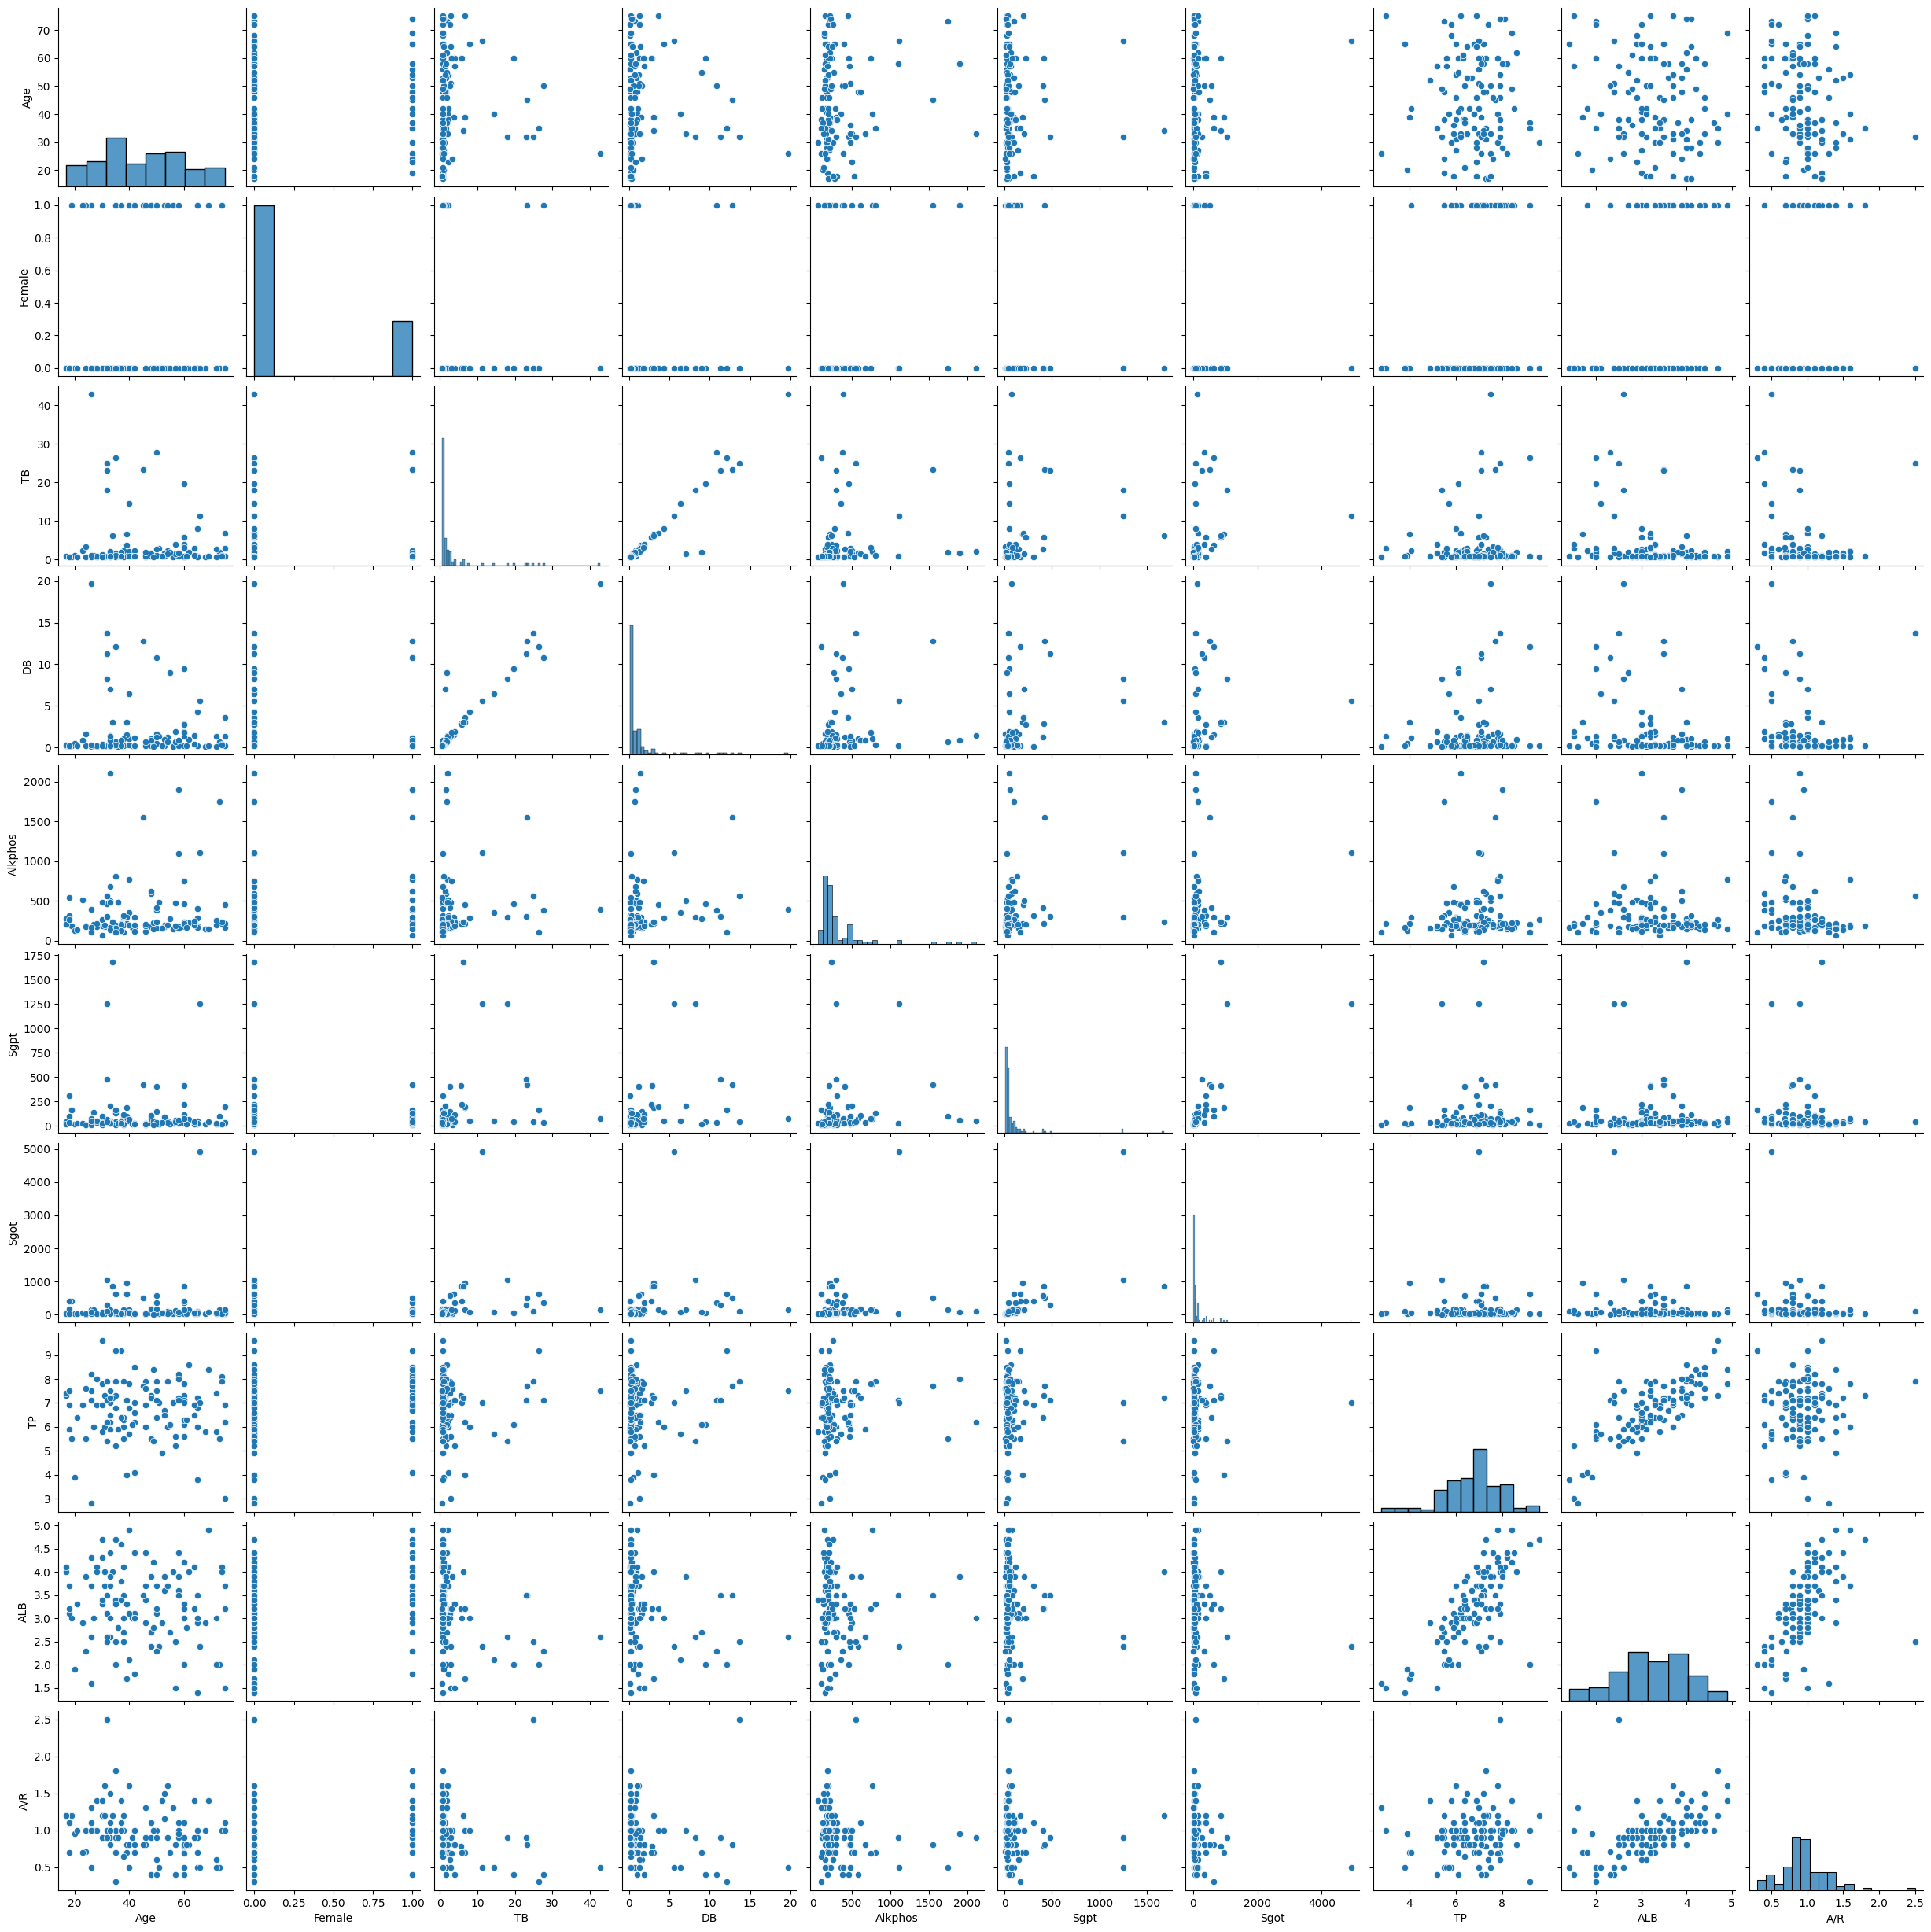

In [12]:
sns.pairplot(data=Liver_data)

In [16]:
Liver_data.isna().sum()

Age        0
Female     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/R        0
dtype: int64